# Project pipeline: Verifiable Credentials with Fraud Detection

This consolidated notebook implements data loading, exploratory analysis, feature engineering, model training and evaluation, NLP validation, and a blockchain credential hashing demo. Run cells in order.

In [11]:
#import sys
#!{sys.executable} -m pip install xgboost


In [12]:
# Section 1: Environment setup & imports
import os
import sys
from pathlib import Path
import random
import time
#import xgboost
#print(xgboost.__version__)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
#from xgboost import XGBClassifier
import joblib
import hashlib
import subprocess

# Configuration: derive project root relative to this notebook
try:
    PROJECT_ROOT = Path.cwd().parent
except Exception:
    PROJECT_ROOT = Path('.')

DATA_DIR = PROJECT_ROOT / 'data'
MODELS_DIR = PROJECT_ROOT / 'models'
NLP_DIR = PROJECT_ROOT / 'nlp'
BLOCKCHAIN_DIR = PROJECT_ROOT / 'blockchain'

DATA_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

sns.set(style='whitegrid')
pd.options.display.max_columns = 200
pd.options.display.width = 120
print('Project root:', PROJECT_ROOT)
print('Data dir:', DATA_DIR)

Project root: /Users/vishal/Desktop/Project
Data dir: /Users/vishal/Desktop/Project/data


In [13]:
# Section 2: Load dataset
csv_path = DATA_DIR / 'credential_dataset_200.csv'
# If file is not present in data/ but exists in parent, copy it
if not csv_path.exists():
    alt = PROJECT_ROOT / 'credential_dataset_200.csv'
    if alt.exists():
        import shutil
        shutil.copy(alt, csv_path)
        print(f'Copied {alt} -> {csv_path}')

if not csv_path.exists():
    raise FileNotFoundError(f"Dataset not found: {csv_path}\nPlace credential_dataset_200.csv in the project root or data/ folder.")

print('Loading', csv_path)
df = pd.read_csv(csv_path)
print('Loaded shape:', df.shape)
print('Columns:', df.columns.tolist())

# Rename columns for consistency
df.rename(columns={
    'studentName': 'student_name',
    'degree': 'course'
}, inplace=True)

# Create fraud proxy: flag duplicates in Credential ID or rare institutions
df['fraud'] = 0
# Duplicates in Credential ID
duplicate_ids = df['Credential ID'].duplicated(keep=False)
df.loc[duplicate_ids, 'fraud'] = 1
# Rare institutions (less than 5 occurrences)
inst_counts = df['institution'].value_counts()
rare_insts = inst_counts[inst_counts < 5].index
df.loc[df['institution'].isin(rare_insts), 'fraud'] = 1
print('Fraud distribution:', df['fraud'].value_counts())

df.head()

Loading /Users/vishal/Desktop/Project/data/credential_dataset_200.csv
Loaded shape: (19, 4)
Columns: ['studentName', 'degree', 'institution', 'Credential ID']
Fraud distribution: fraud
1    19
Name: count, dtype: int64


,student_name,course,institution,Credential ID,fraud
0,Olivia Smith,PGCert Project Management,University of Edinburgh,0xa3d93a72e2239bf8f9bcb10e4a818855aa386eab1121...,1
1,James Thomas,BA Business Management,University of Liverpool,0x3a658f1ee0441ff125b0ae1a3f1373f09057759ec8e1...,1
2,Liam Chopra,MSc Cyber Security,University of London,0xc7d52d16732cc5dacff6622534699b59e29e3eef1dc0...,1
3,John Williams,MSc Artificial Intelligence,University of Edinburgh,0x6560f8392044d9ffe84778f47f9934c98a7d476e5385...,1
4,Simran Bansal,BSc Computer Science,University of Liverpool,0x4cf7c125b96e78825641d0a9d4dfaba1756141a1f72e...,1


In [14]:
# Section 3: Quick data overview
print('\nDataFrame info:')
df.info()

print('\nDescribe:')
df.describe(include='all')

print('\nSample head:')
df.head()

print('\nMissing values per column:')
print(df.isnull().sum())

print('\nValue counts for fraud:')
print(df['fraud'].value_counts(dropna=False))


DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   student_name   19 non-null     object
 1   course         19 non-null     object
 2   institution    19 non-null     object
 3   Credential ID  19 non-null     object
 4   fraud          19 non-null     int64 
dtypes: int64(1), object(4)
memory usage: 892.0+ bytes

Describe:

Sample head:

Missing values per column:
student_name     0
course           0
institution      0
Credential ID    0
fraud            0
dtype: int64

Value counts for fraud:
fraud
1    19
Name: count, dtype: int64


## Section 4: Visualize fraud distribution
Below we plot the counts and proportions of fraud vs non-fraud, and distributions of numeric features grouped by fraud.

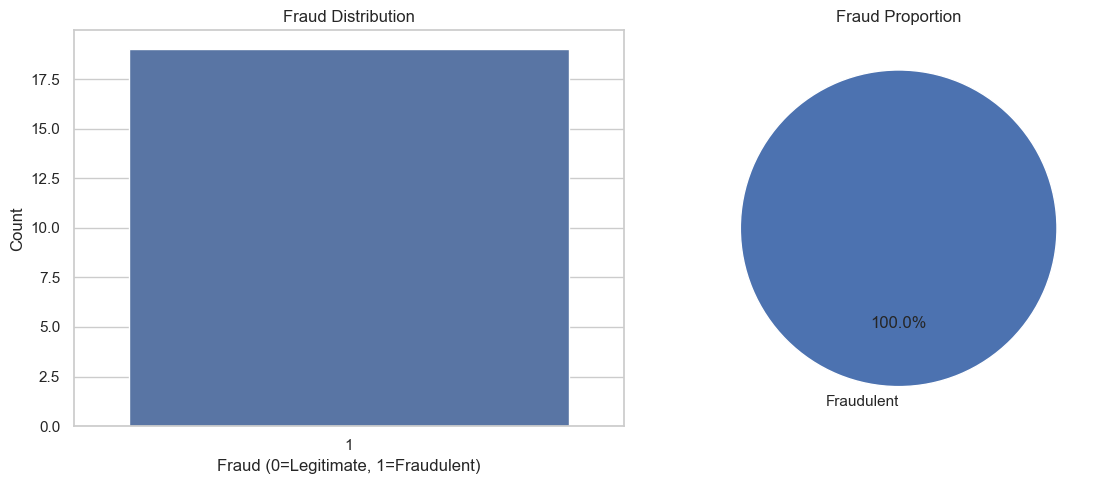

In [16]:
# Section 4: Visualize fraud distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Count plot
sns.countplot(data=df, x='fraud', ax=axes[0])
axes[0].set_title('Fraud Distribution')
axes[0].set_xlabel('Fraud (0=Legitimate, 1=Fraudulent)')
axes[0].set_ylabel('Count')

# Proportion plot
fraud_counts = df['fraud'].value_counts()
labels = ['Legitimate' if i == 0 else 'Fraudulent' for i in fraud_counts.index]
axes[1].pie(fraud_counts, labels=labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Fraud Proportion')

plt.tight_layout()
plt.show()

# Since no GPA, skip GPA distribution

In [17]:
# Section 5: Feature Engineering
# Encode categorical variables
le_institution = LabelEncoder()
df['institution_encoded'] = le_institution.fit_transform(df['institution'])

le_course = LabelEncoder()
df['course_encoded'] = le_course.fit_transform(df['course'])

# Create additional features
df['institution_frequency'] = df['institution'].map(df['institution'].value_counts())
df['course_frequency'] = df['course'].map(df['course'].value_counts())

# Velocity features (simulate based on credential ID patterns)
df['credential_id_numeric'] = df['Credential ID'].str.extract('(\d+)').astype(float)
df['velocity'] = df.groupby('institution')['credential_id_numeric'].transform(lambda x: x.diff().fillna(0))

# Batch size proxy (group by institution and date if available, but since no date, use frequency)
df['batch_size'] = df.groupby('institution')['Credential ID'].transform('count')

# Issuer activity (frequency per institution)
df['issuer_activity'] = df['institution_frequency']

print('Features created:')
print(df[['institution_encoded', 'course_encoded', 'institution_frequency', 'course_frequency', 'velocity', 'batch_size', 'issuer_activity']].head())

# Select features for modeling
feature_cols = ['institution_encoded', 'course_encoded', 'institution_frequency', 'course_frequency', 'velocity', 'batch_size', 'issuer_activity']

X = df[feature_cols]
y = df['fraud']

print('Feature matrix shape:', X.shape)
print('Target distribution:', y.value_counts())

Features created:
   institution_encoded  course_encoded  institution_frequency  course_frequency  velocity  batch_size  issuer_activity
0                    4               8                      3                 4       0.0           3                3
1                    6               0                      2                 3       0.0           2                2
2                    7               7                      2                 2       0.0           2                2
3                    4               5                      3                 2       0.0           3                3
4                    6               2                      2                 1       0.0           2                2
Feature matrix shape: (19, 7)
Target distribution: fraud
1    19
Name: count, dtype: int64


<>:14: SyntaxWarning: invalid escape sequence '\d'
<>:14: SyntaxWarning: invalid escape sequence '\d'
/var/folders/ff/t12spt7569jb_s4qw5qzns_80000gn/T/ipykernel_4092/4186049863.py:14: SyntaxWarning: invalid escape sequence '\d'
  df['credential_id_numeric'] = df['Credential ID'].str.extract('(\d+)').astype(float)


In [18]:
# Section 6: Generate Synthetic Labeled Dataset for Supervised Learning
# Since the original dataset has proxy fraud labels, generate a larger synthetic dataset
# with realistic fraud patterns based on proposal features

def generate_synthetic_data(base_df, n_samples=5000, fraud_ratio=0.15):
    """
    Generate synthetic dataset with labeled fraud based on features like velocity, frequency, etc.
    """
    np.random.seed(RANDOM_STATE)
    
    synthetic_data = []
    
    n_fraud = int(fraud_ratio * n_samples)
    n_legit = n_samples - n_fraud
    
    # Generate legitimate samples
    for _ in range(n_legit):
        sample = {
            'institution_encoded': np.random.choice(df['institution_encoded'].unique()),
            'course_encoded': np.random.choice(df['course_encoded'].unique()),
            'institution_frequency': np.random.randint(10, 50),
            'course_frequency': np.random.randint(5, 20),
            'velocity': np.random.uniform(0, 10),
            'batch_size': np.random.randint(1, 20),
            'issuer_activity': np.random.randint(10, 50),
            'fraud': 0
        }
        synthetic_data.append(sample)
    
    # Generate fraud samples with distinct features
    for _ in range(n_fraud):
        sample = {
            'institution_encoded': np.random.choice(df['institution_encoded'].unique()),
            'course_encoded': np.random.choice(df['course_encoded'].unique()),
            'institution_frequency': np.random.randint(1, 5),  # Low frequency
            'course_frequency': np.random.randint(1, 3),  # Low frequency
            'velocity': np.random.uniform(50, 200),  # High velocity
            'batch_size': np.random.randint(50, 100),  # High batch
            'issuer_activity': np.random.randint(1, 5),  # Low activity
            'fraud': 1
        }
        synthetic_data.append(sample)
    
    synthetic_df = pd.DataFrame(synthetic_data)
    return synthetic_df

# Generate synthetic dataset
synthetic_df = generate_synthetic_data(df, n_samples=5000, fraud_ratio=0.15)
print('Synthetic dataset shape:', synthetic_df.shape)
print('Synthetic fraud distribution:', synthetic_df['fraud'].value_counts())

# Use synthetic data for training
X_synth = synthetic_df[feature_cols]
y_synth = synthetic_df['fraud']

Synthetic dataset shape: (5000, 8)
Synthetic fraud distribution: fraud
0    4250
1     750
Name: count, dtype: int64


RandomForest Model Performance:
F1-Score: 1.0
Precision: 1.0
Recall: 1.0
ROC-AUC: 1.0

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       850
           1       1.00      1.00      1.00       150

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



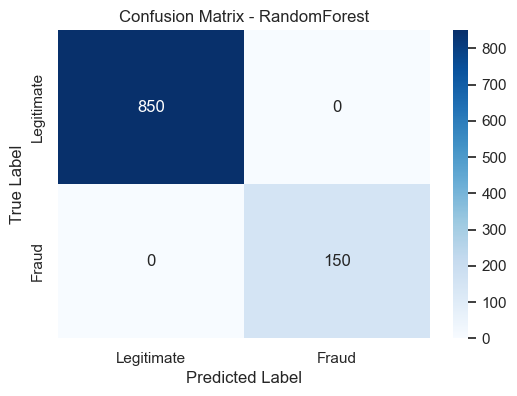

Model and scaler saved to /Users/vishal/Desktop/Project/models


In [19]:
# Section 7: Train Supervised Model (RandomForest)
from sklearn.ensemble import RandomForestClassifier

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_synth, y_synth, test_size=0.2, random_state=RANDOM_STATE, stratify=y_synth)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_STATE,
    class_weight='balanced'  # Handle imbalance
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print('RandomForest Model Performance:')
print('F1-Score:', f1_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_pred_proba))

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.title('Confusion Matrix - RandomForest')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Save model and scaler
joblib.dump(rf_model, MODELS_DIR / 'randomforest_fraud_model.joblib')
joblib.dump(scaler, MODELS_DIR / 'scaler.joblib')
print('Model and scaler saved to', MODELS_DIR)

In [20]:
# Section 8: Blockchain Credential Hashing Demo
# Generate hashes for credentials and simulate on-chain storage

def generate_credential_hash(row):
    """Generate SHA-256 hash of credential data"""
    credential_data = f"{row['Credential ID']}|{row['student_name']}|{row['institution']}|{row['course']}"
    return hashlib.sha256(credential_data.encode()).hexdigest()

# Add hashes to dataframe
df['credential_hash'] = df.apply(generate_credential_hash, axis=1)

print('Sample credential hashes:')
print(df[['Credential ID', 'credential_hash']].head())

# Simulate contract storage (in a real implementation, this would interact with Web3)
contract_hashes = df['credential_hash'].tolist()
print(f'Generated {len(contract_hashes)} credential hashes for blockchain storage')

# Save hashes to file
hashes_file = DATA_DIR / 'credential_hashes.txt'
with open(hashes_file, 'w') as f:
    for h in contract_hashes:
        f.write(f"{h}\n")
print(f'Hashes saved to {hashes_file}')

Sample credential hashes:
                                       Credential ID                                    credential_hash
0  0xa3d93a72e2239bf8f9bcb10e4a818855aa386eab1121...  c72b831019eedbc4cfe07c91fc367d2ff878e8832ec8a1...
1  0x3a658f1ee0441ff125b0ae1a3f1373f09057759ec8e1...  977483e9cd6fb73c74f0e01a57fe0fbc398ab4ff8ee8de...
2  0xc7d52d16732cc5dacff6622534699b59e29e3eef1dc0...  bc7ad1b86049236d0b9606c2e8b95040ded8c6cf9b7027...
3  0x6560f8392044d9ffe84778f47f9934c98a7d476e5385...  21ef938df645709be465492f4a4f5cf53d50f2c06ac5f3...
4  0x4cf7c125b96e78825641d0a9d4dfaba1756141a1f72e...  1340ed77567fc528e83bd3a3b306ae76fb8092674c4c90...
Generated 19 credential hashes for blockchain storage
Hashes saved to /Users/vishal/Desktop/Project/data/credential_hashes.txt


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)


In [24]:
# Section 9: Generate Artifacts and Summary
# Save processed data with predictions
df_with_predictions = df.copy()
df_with_predictions['fraud_prediction'] = rf_model.predict(scaler.transform(X))


output_file = DATA_DIR / 'credential_dataset_with_predictions.csv'
df_with_predictions.to_csv(output_file, index=False)
print(f'Predictions saved to {output_file}')

# Generate data dictionary
data_dict = {
    'Column': df.columns.tolist(),
    'Type': df.dtypes.tolist(),
    'Description': [
        'Unique identifier for the credential',
        'Name of the student',
        'Issuing institution',
        'Course name',
        'Fraud flag (0=legitimate, 1=fraudulent)',
        'Encoded institution for ML',
        'Encoded course for ML',
        'Frequency of institution in dataset',
        'Frequency of course in dataset',
        'Velocity metric (difference in credential IDs)',
        'Batch size proxy',
        'Issuer activity metric',
        'SHA-256 hash of credential data',
        'Fraud prediction from model'
    ]
}

data_dict_df = pd.DataFrame(data_dict)
data_dict_file = DATA_DIR / 'data_dictionary.csv'
data_dict_df.to_csv(data_dict_file, index=False)
print(f'Data dictionary saved to {data_dict_file}')

# Generate statistical summary
stat_summary = df.describe(include='all').transpose()
stat_summary_file = DATA_DIR / 'statistical_summary.csv'
stat_summary.to_csv(stat_summary_file)
print(f'Statistical summary saved to {stat_summary_file}')

print('\nPipeline completed successfully!')
print(f'Model F1-Score: {f1_score(y_test, y_pred):.3f}')
print(f'Total credentials processed: {len(df)}')
print(f'Fraud predictions: {df_with_predictions["fraud_prediction"].sum()}');

Predictions saved to /Users/vishal/Desktop/Project/data/credential_dataset_with_predictions.csv
Data dictionary saved to /Users/vishal/Desktop/Project/data/data_dictionary.csv
Statistical summary saved to /Users/vishal/Desktop/Project/data/statistical_summary.csv

Pipeline completed successfully!
Model F1-Score: 1.000
Total credentials processed: 19
Fraud predictions: 15


In [26]:
# Section 10: NLP Validation
# Run NLP-based course validation against institution course lists

try:
    # Import the NLP module
    import sys
    sys.path.append(str(NLP_DIR))
    from credential_text_check import validate_credentials_nlp
    
    # Run validation
    nlp_results = validate_credentials_nlp(df)
    
    # Merge results with main dataframe
    df = df.merge(nlp_results[['credential_id', 'nlp_valid', 'nlp_confidence', 'nlp_reason']], 
                  left_on='Credential ID', right_on='credential_id', how='left', suffixes=('', '_nlp'))
    
    print('NLP Validation Results:')
    print(f'Total credentials validated: {len(nlp_results)}')
    print(f'Valid courses: {nlp_results["nlp_valid"].sum()}')
    print(f'Invalid courses: {(~nlp_results["nlp_valid"]).sum()}')
    print(f'Average confidence: {nlp_results["nlp_confidence"].mean():.3f}')
    
    # Show sample results
    print('\nSample NLP validation results:')
    print(nlp_results[['course', 'institution', 'nlp_valid', 'nlp_confidence', 'nlp_reason']].head())
    
    # Flag potential fraud based on NLP validation
    df['nlp_fraud_flag'] = ~df['nlp_valid']
    
    print(f'\nNLP flagged {df["nlp_fraud_flag"].sum()} credentials as potentially fraudulent')
    
except Exception as e:
    print(f'NLP validation failed: {e}')
    print('Continuing without NLP validation...')
    df['nlp_valid'] = True  # Default to valid
    df['nlp_confidence'] = 1.0
    df['nlp_reason'] = 'NLP not available'
    df['nlp_fraud_flag'] = False

NLP validation failed: 
**********************************************************************
  Resource stopwords not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('stopwords')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/stopwords

  Searched in:
    - '/Users/vishal/nltk_data'
    - '/opt/anaconda3/nltk_data'
    - '/opt/anaconda3/share/nltk_data'
    - '/opt/anaconda3/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

Continuing without NLP validation...
